# Comparison between Firecrown prediction and saved Sacc data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sacc

import os

os.environ["CLMM_MODELING_BACKEND"] = (
    "ccl"  # Need to use NumCosmo as CLMM's backend as well.
)
import clmm  # noqa: E402
from clmm import Cosmology  # noqa: E402

import math
import itertools

from numcosmo_py import Nc
from numcosmo_py import Ncm

from astropy.table import Table

from astropy.io import fits
from scipy import stats
from typing import Any
import pyccl as ccl


## Generate Data with NumCosmo
- Note that we are using NC as the CLMM backend and the CLPred uses CCL.

In this next cell, we will generate cluster with NumCosmo.  We use the richness mass relation and save the data on a SACC file. I want to read the data from SACC and compare to the saved data first to see if there is any problem.


In [2]:
def generate_sacc_file() -> Any:
    """Generate a SACC file for cluster number counts and cluster deltasigma."""
    H0 = 71.0
    Ob0 = 0.0448
    Odm0 = 0.22
    n_s = 0.963
    sigma8 = 0.8

    cosmo = Nc.HICosmoDECpl()
    reion = Nc.HIReionCamb.new()
    prim = Nc.HIPrimPowerLaw.new()

    cosmo.add_submodel(reion)
    cosmo.add_submodel(prim)

    dist = Nc.Distance.new(2.0)
    tf = Nc.TransferFuncEH.new()

    psml = Nc.PowspecMLTransfer.new(tf)

    # psml = Nc.PowspecMLCBE.new ()
    psml.require_kmin(1.0e-6)
    psml.require_kmax(1.0e3)

    psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
    psf.set_best_lnr0()

    cosmo.props.H0 = H0
    cosmo.props.Omegab = Ob0
    cosmo.props.Omegac = Odm0

    cosmo.omega_x2omega_k()
    cosmo.param_set_by_name("Omegak", 0.0)

    prim.props.n_SA = n_s

    old_amplitude = math.exp(prim.props.ln10e10ASA)
    prim.props.ln10e10ASA = math.log((sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude)

    # CosmoSim_proxy model
    # M_0, z_0

    area = 439.78986
    lnRl = 0.0
    lnRu = 5.0
    zl = 0.2
    zu = 0.65

    # NumCosmo proxy model based on arxiv 1904.07524v2
    cluster_z = Nc.ClusterRedshiftNodist(z_max=zu, z_min=zl)
    cluster_m = Nc.ClusterMassAscaso(
        M0=3.0e14 / 0.71, z0=0.6, lnRichness_min=lnRl, lnRichness_max=lnRu
    )
    cluster_m.param_set_by_name("mup0", 3.19)
    cluster_m.param_set_by_name("mup1", 2 / np.log(10))
    cluster_m.param_set_by_name("mup2", -0.7 / np.log(10))
    cluster_m.param_set_by_name("sigmap0", 0.33)
    cluster_m.param_set_by_name("sigmap1", -0.08 / np.log(10))
    cluster_m.param_set_by_name("sigmap2", 0 / np.log(10))

    # Numcosmo Mass Function
    # First we need to define the multiplicity function here we will use the tinker
    mulf = Nc.MultiplicityFuncTinker.new()
    mulf.set_linear_interp(True)  # This _cclreproduces the linear interpolation done in CCL
    mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
    mulf.set_Delta(200)

    # Second we need to construct a filtered power spectrum
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.set_area_sd(area)

    # Cluster Abundance Obj
    ca = Nc.ClusterAbundance.new(hmf, None)

    # Number Counts object
    ncount = Nc.DataClusterNCount.new(
        ca, "NcClusterRedshiftNodist", "NcClusterMassAscaso"
    )
    ca.prepare(cosmo, cluster_z, cluster_m)
    mset = Ncm.MSet.new_array([cosmo, cluster_z, cluster_m])

    rng = Ncm.RNG.seeded_new(None, 2)
    ncount.init_from_sampling(mset, area * ((np.pi / 180) ** 2), rng)

    ncount.catalog_save("/pbs/home/e/ebarroso/CosmoPipeline/theory_test/ncount_rich.fits", True)
    ncdata_fits = fits.open("ncount_rich.fits")
    ncdata_data = ncdata_fits[1].data  # pylint: disable-msg=no-member
    ncdata_Table = Table(ncdata_data)

    # ## Saving in SACC format

    data_table = ncdata_Table[ncdata_Table["LNM_OBS"] > 2]
    cluster_z = data_table["Z_OBS"]
    cluster_lnm = data_table["LNM_OBS"]
    cluster_richness = cluster_lnm / np.log(10.0)
    cluster_logM = data_table["LNM_TRUE"] / np.log(10.0)

    # ## Count halos in the $N_{\rm richness} \times N_z$ richness-redshift plane

    N_richness = 5  # number of richness bins
    N_z = 4  # number of redshift bins

    cluster_counts, z_edges, richness_edges, _ = stats.binned_statistic_2d(
        cluster_z, cluster_richness, cluster_logM, "count", bins=[N_z, N_richness]
    )
    mean_logM = stats.binned_statistic_2d(
        cluster_z,
        cluster_richness,
        cluster_logM,
        "mean",
        bins=[z_edges, richness_edges],
    ).statistic
    std_logM = stats.binned_statistic_2d(
        cluster_z, cluster_richness, cluster_logM, "std", bins=[z_edges, richness_edges]
    ).statistic

    var_mean_logM = std_logM**2 / cluster_counts

    # Use CLMM to create a mock DeltaSigma profile to add to the SACC file later
    cosmo_clmm = Cosmology()
    cosmo_ccl = ccl.Cosmology(
            Omega_b=0.0448, Omega_c=0.22, sigma8=0.8, w0=-1, wa=0, h=0.71, n_s=0.96
        )
    cosmo_clmm._init_from_cosmo(cosmo_ccl)
    moo = clmm.Modeling(massdef="critical", delta_mdef=200, halo_profile_model="nfw")
    moo.set_cosmo(cosmo_clmm)
    # assuming the same concentration for all masses. Not realistic, but avoid having to call a mass-concentration relation.
    moo.set_concentration(4)

    # we'll need the mean redshift of the clusters in the redshift bin
    mean_z = stats.binned_statistic_2d(
        cluster_z,
        cluster_richness,
        cluster_z,
        "mean",
        bins=[z_edges, richness_edges],
    ).statistic
    radius_edges = clmm.make_bins(
        0.3, 6.0, nbins=6, method="evenlog10width"
    )  # 6 radial bins log-spaced between 0.3 and 6 Mpc
    # radius_edges = clmm.make_bins(
    #     0.8, 10.0, nbins=7, method="evenlog10width"
    # )  # 6 radial bins log-spaced between 0.3 and 6 Mpc

    radius_centers = []
    for i, radius_bin in enumerate(zip(radius_edges[:-1], radius_edges[1:])):
        radius_lower, radius_upper = radius_bin
        j = i + 2
        radius_center = np.mean(radius_edges[i:j])
        radius_centers.append(radius_center)
    cluster_DeltaSigma = []
    for redshift, log_mass in zip(cluster_z, cluster_logM):
        mass = 10**log_mass
        moo.set_mass(mass)
        cluster_DeltaSigma.append(
            moo.eval_excess_surface_density(radius_centers, redshift)
        )
    cluster_DeltaSigma = np.array(cluster_DeltaSigma)
    richness_inds = np.digitize(cluster_richness, richness_edges) - 1
    z_inds = np.digitize(cluster_z, z_edges) - 1
    mean_DeltaSigma = np.array(
        [
            [
                np.mean(
                    cluster_DeltaSigma[(richness_inds == i) * (z_inds == j)], axis=0
                )
                for i in range(N_richness)
            ]
            for j in range(N_z)
        ]
    )
    std_DeltaSigma = np.array(
        [
            [
                np.std(cluster_DeltaSigma[(richness_inds == i) * (z_inds == j)], axis=0)
                for i in range(N_richness)
            ]
            for j in range(N_z)
        ]
    )

    var_mean_DeltaSigma = std_DeltaSigma**2 / cluster_counts[..., None]
    # correlation matrix - the "large blocks" correspond to the $N_z$ redshift bins.
    # In each redshift bin are the $N_{\rm richness}$ richness bins.**
    # var_mean_DeltaSigma = np.ones(len(var_mean_DeltaSigma.flatten()))
    covariance = np.diag(
        np.concatenate(
            (
                cluster_counts.flatten(),
                var_mean_logM.flatten(),
                var_mean_DeltaSigma.flatten(),
            )
        )
    )

    # Prepare the SACC file
    s_count = sacc.Sacc()
    bin_z_labels = []
    bin_richness_labels = []
    bin_radius_labels = []

    survey_name = "numcosmo_simulated_redshift_richness_deltasigma"
    s_count.add_tracer("survey", survey_name, area)
    z_bins = []
    rich_bins = []
    for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
        lower, upper = z_bin
        bin_z_label = f"bin_z_{i}"
        s_count.add_tracer("bin_z", bin_z_label, lower, upper)
        bin_z_labels.append(bin_z_label)
        z_bins.append((lower,upper))
    for i, richness_bin in enumerate(zip(richness_edges[:-1], richness_edges[1:])):
        lower, upper = richness_bin
        bin_richness_label = f"rich_{i}"
        s_count.add_tracer("bin_richness", bin_richness_label, lower, upper)
        bin_richness_labels.append(bin_richness_label)
        rich_bins.append((lower,upper))
    for i, radius_bin in enumerate(zip(radius_edges[:-1], radius_edges[1:])):
        radius_lower, radius_upper = radius_bin
        j = i + 2
        radius_center = np.mean(radius_edges[i : j])
        bin_radius_label = f"bin_radius_{i}"
        s_count.add_tracer(
            "bin_radius", bin_radius_label, radius_lower, radius_upper, radius_center
        )
        bin_radius_labels.append(bin_radius_label)

    #  pylint: disable-next=no-member
    cluster_count = sacc.standard_types.cluster_counts
    #  pylint: disable-next=no-member
    cluster_mean_log_mass = sacc.standard_types.cluster_mean_log_mass
    #  pylint: disable-next=no-member
    cluster_mean_DeltaSigma = sacc.standard_types.cluster_shear

    counts_and_edges = zip(
        cluster_counts.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
    )

    mean_logM_and_edges = zip(
        mean_logM.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
    )
    mean_deltasigma_and_edges = zip( itertools.product(bin_z_labels, bin_richness_labels) )

    redshifts_masses_and_edges = zip(
        mean_z.flatten(),
        mean_logM.flatten(),
        itertools.product(bin_z_labels, bin_richness_labels),
    )

    for counts, (bin_z_label, bin_richness_label) in counts_and_edges:
        s_count.add_data_point(
            cluster_count, (survey_name, bin_z_label, bin_richness_label), int(counts)
        )

    for bin_mean_logM, (bin_z_label, bin_richness_label) in mean_logM_and_edges:
        s_count.add_data_point(
            cluster_mean_log_mass,
            (survey_name, bin_z_label, bin_richness_label),
            bin_mean_logM,
        )
    profile_list = []
    for j, bin_z_label in enumerate(bin_z_labels):
        for k, bin_richness_label in enumerate(bin_richness_labels):
            for i, bin_radius_label in enumerate(bin_radius_labels):
                profile = mean_DeltaSigma[j][k][i]
                profile_list.append(profile)
                s_count.add_data_point(
                    cluster_mean_DeltaSigma,
                    (survey_name, bin_z_label, bin_richness_label, bin_radius_label),
                    profile,
                )

    # ### Then the add the covariance and save the file
    s_count.add_covariance(covariance)
    s_count.to_canonical_order()
    s_count.save_fits("deltasigma_profile_test_ccl.fits",overwrite=True)
    
    return mean_DeltaSigma, radius_centers, z_bins, rich_bins, s_count, N_z, N_richness, cosmo, cluster_counts
    

if __name__ == "__main__":
    Ncm.cfg_init()
    mean_DeltaSigma, rbins, z_bins, rich_bins, sac_s, nz, nr, cosmo, counts = generate_sacc_file()

## Read Sacc data

In [3]:
s_read = sacc.Sacc.load_fits("deltasigma_profile_test_ccl.fits") 
data_points = s_read.get_data_points(f"{sacc.standard_types.cluster_shear}")
mean_DeltaSigma_read = [point.value for point in s_read.get_data_points(f"{sacc.standard_types.cluster_shear}")]
##Since we saved in redshift bins and then richness bins, this list will also be in this order
bin_DeltaSigma = [mean_DeltaSigma_read[i*len(rbins):i*len(rbins) + len(rbins)] for i in range(0, nz*nr)]
#print(mean_DeltaSigma_read)


### Comparing generated data to saved data
In this cell, we are comparing the data saved in the SACC file and the data read by Firecrown.

[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]


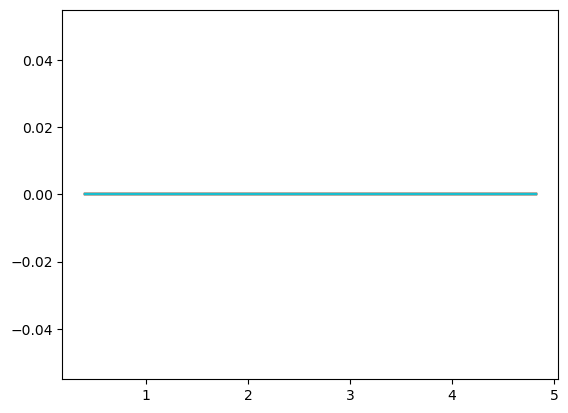

In [4]:
bin_ij = 0
for z_bin in range(nz):
    for rich_bin in range(nr):
        diff = np.array(bin_DeltaSigma[bin_ij]) - mean_DeltaSigma[z_bin][rich_bin]
        print(diff)
        plt.plot(rbins, diff)
        bin_ij+=1

In [5]:
from firecrown.models.cluster.recipes.murata_binned_spec_z_deltasigma import MurataBinnedSpecZDeltaSigmaRecipe as MDS
from firecrown.models.cluster.deltasigma import ClusterDeltaSigma
from firecrown.models.cluster.deltasigma_data import DeltaSigmaData
from firecrown.models.cluster.abundance import ClusterAbundance
from firecrown.models.cluster.binning import SaccBin
from firecrown.models.cluster.properties import ClusterProperty
from firecrown.likelihood.binned_cluster_number_counts_deltasigma import BinnedClusterDeltaSigma
from firecrown.modeling_tools import ModelingTools

# Computing Firecrown Prediction
In the next cells, we will call the firecrown prediction module and compute the profiles with the fiducial values we used to generate the data.

To do so we need to :
- Initiate the cluster_abundance and cluster_deltasigma objects
- Initiate the recipe with the correct parameters
- Call the statistics object prediction

### Initiating cluster objects

In [6]:
hmf = ccl.halos.MassFuncTinker08(mass_def="200c")
min_mass, max_mass = 13.0, 16.0
min_z, max_z = 0.2, 0.8
cluster_abundance = ClusterAbundance((min_mass, max_mass), (min_z, max_z), hmf)
cluster_deltasigma = ClusterDeltaSigma((min_mass, max_mass), (min_z, max_z), hmf, True)
cosmo_ccl = ccl.Cosmology(
            Omega_b=0.0448, Omega_c=0.22, sigma8=0.8, w0=-1, wa=0, h=0.71, n_s=0.96
        )
sky_area = 439.78986

## Initiating Recipe
The recipe is MDS. Once we initiate it, we need to set the right parameters

In [7]:
survey_nm = "numcosmo_simulated_redshift_richness_deltasigma"

mds = MDS()

mds.mass_distribution.__setattr__('mu_p0', 3.19)
mds.mass_distribution.__setattr__('mu_p1', 2 / np.log(10) )
mds.mass_distribution.__setattr__('mu_p2', -0.7 / np.log(10))
mds.mass_distribution.__setattr__('sigma_p0', 0.33)
mds.mass_distribution.__setattr__('sigma_p1', -0.08 / np.log(10))
mds.mass_distribution.__setattr__('sigma_p2', 0.0)
mds.mass_distribution.pivot_mass = np.log(3.0e14 / 0.71)
mds.mass_distribution.pivot_redshift = 0.6

cluster_deltasigma.update_ingredients(cosmo_ccl)
cluster_deltasigma.__setattr__("cluster_conc", 4.0)
cluster_abundance.update_ingredients(cosmo_ccl)
tools = ModelingTools(cluster_abundance=cluster_abundance, cluster_deltasigma=cluster_deltasigma)

## Computing profile Firecrown

In [8]:
bin_cl_theory = BinnedClusterDeltaSigma(ClusterProperty.DELTASIGMA, survey_nm, mds)
bin_cl_theory.read(s_read)

firecrown_pred = bin_cl_theory.get_binned_cluster_property(tools, ClusterProperty.DELTASIGMA)
firecrown_pred = np.array(firecrown_pred)

In [9]:
truth_data = np.array(mean_DeltaSigma).flatten()
diff_fd = (firecrown_pred - truth_data) / truth_data
print(f"Dfference between Firecrown and data {diff_fd}")

Dfference between Firecrown and data [-0.03331241 -0.03619702 -0.03862798 -0.04056376 -0.04205751 -0.0431961
  0.01318774  0.0135695   0.01374305  0.01374856  0.01365433  0.0135188
  0.03450457  0.03938558  0.04410473  0.04828367  0.05176002  0.05454263
  0.01287742  0.01451381  0.01648374  0.01853421  0.02044387  0.02209175
  0.11610593  0.13804965  0.16070407  0.18184714  0.20010901  0.21507741
  0.01375461  0.01491639  0.01587457  0.01662059  0.01718458  0.01760737
  0.01696448  0.01915412  0.0211284   0.02279332  0.02413583  0.02519139
 -0.00576546 -0.00602162 -0.00612718 -0.00611681 -0.00604187 -0.00592584
  0.09431467  0.10819973  0.12206915  0.13466234  0.14532333  0.15395209
  0.12394399  0.14234548  0.16174873  0.18014388  0.19620954  0.20948097
 -0.01621052 -0.01797148 -0.01948417 -0.02070955 -0.02166893 -0.02240891
  0.02518613  0.02747263  0.02945559  0.03107589  0.03235269  0.03334104
  0.01256958  0.01292013  0.01309684  0.01314544  0.01312221  0.01306871
  0.05549289  0.

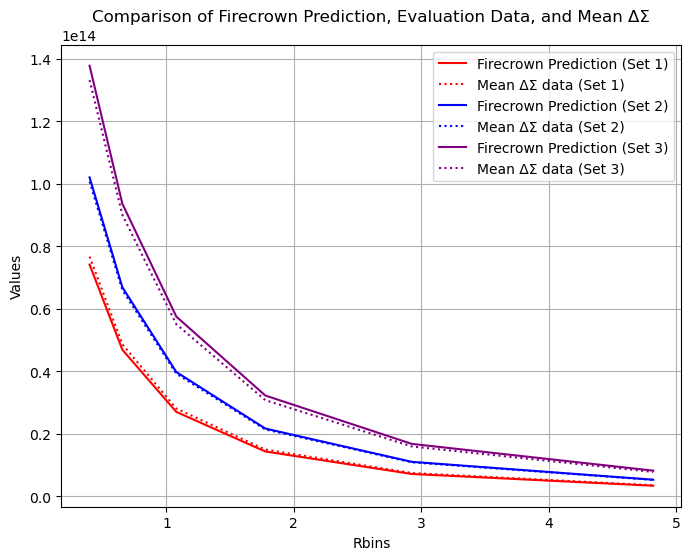

In [10]:
interval = len(rbins)
colors = ['red', 'blue', 'purple']
labels = ['Firecrown Prediction', 'Mean ΔΣ data']

plt.figure(figsize=(8, 6))

for i in range(3):
    start = i * interval
    end = start + interval

    plt.plot(rbins, firecrown_pred[start:end], color=colors[i], linestyle='-', label=f"{labels[0]} (Set {i+1})")
    plt.plot(rbins, mean_DeltaSigma.flatten()[start:end], color=colors[i], linestyle=':', label=f"{labels[1]} (Set {i+1})")

plt.xlabel("Rbins")
plt.ylabel("Values")
plt.title("Comparison of Firecrown Prediction, Evaluation Data, and Mean ΔΣ")
plt.legend()
plt.grid(True)

plt.show()